In [1]:
from pycocotools.coco import COCO

import torchvision

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

In [2]:
dataDir='coco'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
annFile

'coco/annotations/instances_train2017.json'

In [3]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=12.44s)
creating index...
index created!


In [4]:
coco.info()

description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01


In [5]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
sports electronic person kitchen indoor appliance food accessory animal vehicle furniture outdoor


In [6]:
img = coco.loadImgs(coco.getImgIds()[0])
img

[{'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895}]

In [7]:
ann = coco.loadAnns(coco.getAnnIds()[0])
ann

[{'segmentation': [[239.97,
    260.24,
    222.04,
    270.49,
    199.84,
    253.41,
    213.5,
    227.79,
    259.62,
    200.46,
    274.13,
    202.17,
    277.55,
    210.71,
    249.37,
    253.41,
    237.41,
    264.51,
    242.54,
    261.95,
    228.87,
    271.34]],
  'area': 2765.1486500000005,
  'iscrowd': 0,
  'image_id': 558840,
  'bbox': [199.84, 200.46, 77.71, 70.88],
  'category_id': 58,
  'id': 156}]

In [8]:
# Get categorie, annotation and image ids
catIds = coco.getCatIds(supNms="vehicle")
annIds = coco.getAnnIds(catIds=catIds)
imgIds = []
for i in catIds:
    imgIds.extend(coco.getImgIds(catIds=i))

len(catIds), len(annIds), len(imgIds)

(8, 96212, 38683)

{'license': 6, 'file_name': '000000272899.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000272899.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-17 02:07:51', 'flickr_url': 'http://farm9.staticflickr.com/8200/8152915265_f1a2126c97_z.jpg', 'id': 272899}


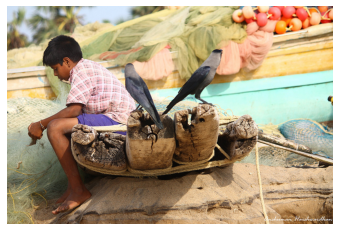

In [9]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

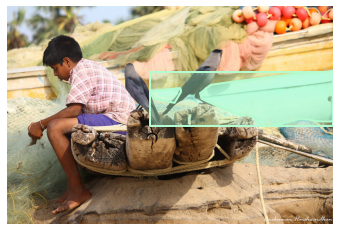

In [10]:
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [47]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from pycocotools.coco import COCO

from PIL import Image
from typing import Any, Callable, Optional, Tuple, List
import os


class COCODataset(Dataset):
    def __init__(self, 
                 is_train: str, 
                 data_type: str, 
                 image_size: int = 448, 
                 num_grid: int = 7, 
                 num_bboxes: int = 2, 
                 num_classes: int = 80,
                 transforms: List[Callable] = None) -> None:
        """ Constructor
        Args:
            is_train (str): [description]
            data_type (str): [description]
            image_size (int, optional): [description]. Defaults to 448.
            num_grid (int, optional): [description]. Defaults to 7.
            num_bboxes (int, optional): [description]. Defaults to 2.
            num_classes (int, optional): [description]. Defaults to 80.
            transforms (List[Callable], optional): [description]. Defaults to None.
        """
        
        self.is_train = is_train
        self.image_size = image_size
        
        self.S = num_grid
        self.B = num_bboxes
        self.C = num_classes
    
        self.data_dir = "coco"
        self.data_type = data_type
        ann_path ='{}/annotations/instances_{}.json'.format(self.data_dir, self.data_type)
        self.coco = COCO(ann_path)
        self.ids = list(self.coco.imgs.keys())
        
        self.transforms = transforms
        
    def __getitem__(self, index: int) -> Tuple:
        """ 
        Args:
            index (int): index of image and annotation to process and return
        Returns:
            tuple: 
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        boxes = [ann["bbox"] for ann in anns]  # [[x, y, width, height],...]
        labels = [ann["category_id"] for ann in anns]
        
        img_path = coco.loadImgs(img_id)[0]["file_name"]
        img = Image.open(os.path.join(self.data_dir, self.data_type, img_path))
        
        # Transformations should happen her
        if self.transforms is not None:
            for t in self.transforms:
                img, boxes = t(img, boxes)
        
        boxes = torch.from_numpy(np.array(boxes))
        boxes = self.center_boxes(boxes)
        boxes = self.normalize_boxes(boxes, img.size)
        print(boxes)
        
        # Need to resize the picture first
        targets = self.encode(boxes, labels)
        #img = img / 255.0  # Simple normalization, map [0, 255] -> [0, 1]
        return img, targets, anns
    
    def center_boxes(self, boxes: torch.Tensor) -> torch.Tensor:
        """ Move upper left corner to middle of bbox and half w and h
        Args:
            boxes (tensor): tensor of bboxes on the COCO format, size [n_bboxes, 4]
        Returns:
            tensor: tensor of bboxes where xy represent the center of the bboxes
        """
        #boxes[:, 2:] *= 0.5
        boxes[:, :2] += 0.5 * boxes[:, 2:]
        return boxes
    
    def normalize_boxes(self, boxes, image_size) -> torch.Tensor:
        """ Normalize bboxes from 0.0 to 1.0 w.r.t. image size
        Args:
            boxes (tensor): tensor of centered bboxes
            image_size (tuple): width and hight of current image
        Returns:
            tensor: tensor of bboxes normalized w.r.t. image size
        """
        w, h = image_size[0], image_size[1]
        boxes /= torch.Tensor([[w, h, w, h]]).expand_as(boxes)
        return boxes
    
    def encode(self, boxes: torch.Tensor, labels: List[int]) -> torch.Tensor:
        """ Encode bbox coordinates and class labels as one target tensor
        Args:
            boxes (tensor): tensor of centered bboxes. Normalized w.r.t. image widht/height, size [n_bboxes, 4]
            lables (list of int): list of category id, size [n_bboxes]
        Returns:
            tensor: An encoded representation of bboxes, size [S, S, B * 5 + C], 5=(x, y, w, h, conf)
        """
        N = self.B * 5 + self.C
        targets = torch.zeros(self.S, self.S, N)
        
        cell_size = 1.0 / float(self.S)  # We use 1.0 as the boxes has been normalize w.r.t. image shape
        
        for b in range(len(boxes)):
            xy = boxes[b, :2]
            wh = boxes[b, 2:]
            label = labels[b]
            
            # Find grid cell the center of the bbox belongs to
            ij = (xy / cell_size).floor()
            i, j = int(ij[0]), int(ij[1])
            
            # Normalize the bbox to the size of the grid cell
            c_xy =  ij * cell_size # Top left corner of cell
            xy_normalized = (xy - c_xy) / cell_size
            
            # Assign the targets tensor values for bbox
            for k in range(self.B):
                s = 5 * k
                targets[i, j, s:s+2] = xy_normalized
                targets[i, j, s+2:s+4] = wh
                targets[i, j, s+4] = 1.0
            targets[i, j, 5 * self.B + label] = 1.0
            
        return targets

In [48]:
train = COCODataset(is_train=True, 
                    data_type="train2017")

loading annotations into memory...
Done (t=13.04s)
creating index...
index created!


In [164]:
img, target, anns = train[0]

tensor([[0.6491, 0.7027, 0.1757, 0.5932],
        [0.6513, 0.4792, 0.2404, 0.8354],
        [0.7650, 0.5469, 0.0561, 0.1336],
        [0.7833, 0.5578, 0.0479, 0.0972]], dtype=torch.float64)


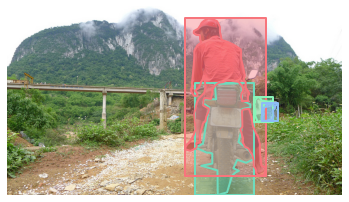

In [50]:
plt.imshow(img); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)
# We can see that one of the objects gets lost, when we haven't predicted anything

# Loss function

In [179]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def coco_to_coords(boxes: torch.Tensor) -> torch.Tensor:
    """ Transform COCO bboxes to bboxes on the format [x1, y1, x2, y2]
    Args:
        boxes (tensor): boxes on the format [x, y, w, h], size [batch_size, 4]
    Returns:
        tensor: boxes on the format [x1, y1, x2, y2], top left and bottom right corners of boxes, size [batch_size, 4]
    """
    boxes[:, 2:] = boxes[:, :2] + boxes[:, 2:]
    return boxes

def coords_to_coco(boxes: torch.Tensor) -> torch.Tensor:
    """ Transform bboxes on the format [x1, y1, x2, y2] to COCO bboxes [x, y, w, h]
    Args:
        boxes (tensor): boxes on the format [x1, y1, x2, y2], size [batch_size, 4]
    Returns:
        tensor: boxes on the format [x, y, w, h], top left corner and widht/height of boxes, size [batch_size, 4]
    """
    boxes[:, 2:] = boxes[:, 2:] - boxes[:, :2]
    return boxes

class YOLOv1Loss(nn.Module):
    def __init__(self, 
                 num_grid: int = 7, 
                 num_bboxes: int = 2, 
                 num_classes: int = 80,
                 lambda_coord: int = 5.0,
                 lambda_noobj: int = 0.5
                 ) -> None:
        """ Constructor
        Args:
            num_grid: (int)
            num_bboxes: (int)
            num_classes: (int)
            lambda_coord: (float)
            lambda_noobj: (float)
        """
        super(YOLOv1Loss, self).__init__()
        
        self.S = num_grid
        self.B = num_bboxes
        self.C = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        
    def IoU(self, bboxes1: torch.Tensor, bboxes2: torch.Tensor) -> float:
        """ Compute the Intersection over Union
        Args:
            bboxes1 (tensor): bounding boxes on format [x1, y1, x2, y2], size [N, 4]
            bboxes2 (tensor): bounding boxes on format [x1, y1, x2, y2], size [M, 4]
        Returns:
            iou (tensor): Intersection over Union between bboxes1 and bboxes2, size [N, M]
        """
        N = bboxes1.size(0)
        M = bboxes2.size(0)
        
        # Top left corner of intersection
        tl = torch.max(
            bboxes1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bboxes2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        
        # Bottom right corner of intersection
        br = torch.min(
            bboxes1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bboxes2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        
        wh = br - tl
        print("wh", wh)
        wh[wh < 0] = 0
        intersection = wh[:, :, 0] * wh[:, :, 1]

        bboxes1_area = (bboxes1[:, 2] - bboxes1[:, 0]) * (bboxes1[:, 3] - bboxes1[:, 1])
        bboxes2_area = (bboxes2[:, 2] - bboxes2[:, 0]) * (bboxes2[:, 3] - bboxes2[:, 1])
        bboxes1_area = bboxes1_area.unsqueeze(1).expand_as(intersection)
        bboxes2_area = bboxes2_area.unsqueeze(0).expand_as(intersection)

        union = bboxes1_area + bboxes2_area - intersection
        iou = intersection / union
        return iou
    
    def GIoU(self, bboxes1: torch.Tensor, bboxes2: torch.Tensor) -> float:
        """ Compute the Generalized Intersection over Union
        https://arxiv.org/pdf/1902.09630.pdf
        Args:
            bboxes1 (tensor): bounding boxes, size [batch_size, 4]
            bboxes2 (tensor): bounding boxes, size [batch_size, 4]
        Returns:
            giou (tensor): Generalized Intersection over Union between bboxes1 and bboxes2, size [batch_size, 1]
        """
        iou = IoU(bboxes1, bboxes2)
        giou = 0.0
        return giou
        
    def forward(self, pred_tensor: torch.Tensor, target_tensor: torch.Tensor) -> torch.float64:
        """ Compute loss based on https://arxiv.org/pdf/1506.02640.pdf
        Args:
            pred_tensor (tensor): model predictions, bboxes on yolo form [x, y, w, h], size [batch_size, S, S, B * 5 + C]
            target_tensor (tensor): targets, size [batch_size, S, S, B * 5 + C]
        """
        batch_size = pred_tensor.size(0)
        N = 5 * self.B + self.C
        
        # get mask for coord and noobj grid cells
        noobj_mask = target_tensor[:, :, :, 4] == 0
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor)
        coord_mask = target_tensor[:, :, :, 4] > 0.0
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor)
        
        # Compute noobj confidence loss for grid cells not containing objects
        noobj_pred = pred_tensor.masked_select(noobj_mask).view(-1, N)
        noobj_target = target_tensor.masked_select(noobj_mask).view(-1, N)
        conf_columns = [4 + 5*b for b in range(self.B)]
        noobj_conf_pred = noobj_pred[:, conf_columns]
        noobj_conf_target = noobj_target[:, conf_columns]        
        noobj_conf_loss = F.mse_loss(noobj_conf_pred, noobj_conf_target, reduction="sum")
        
        # Compute loss for coord grid cells containing objects
        # TODO: Denormalize the 
        coord_pred = pred_tensor.masked_select(coord_mask).view(-1, N)
        coord_target = target_tensor.masked_select(coord_mask).view(-1, N)
        
        # TODO: Pick predicted bbox of the B bboxes that has the highest IoU with the target
        bboxes_pred = coord_pred[:, :5*self.B].contiguous().view(-1, 5)
        bboxes_target = coord_target[:, :5*self.B].contiguous().view(-1, 5)
        
        bboxes_pred_mask = torch.BoolTensor(bboxes_pred.size()).fill_(False)
        target_iou = torch.zeros(bboxes_target.size(0))
        
        for i in range(0, bboxes_target.size(0), self.B):
            pred = bboxes_pred[i:i+self.B]  # predicted bboxes in gird cell i
            print("pred", pred)
            pred_xyxy = torch.as_tensor(pred)  # size [B, 5]
            print("pred_xyxy", pred_xyxy)
            pred_xyxy[:, :2] = pred[:, :2] * (1 / float(self.S)) - 0.5 * pred[:, 2:4]
            print("pred_xyxy", pred_xyxy)
            pred_xyxy[:, 2:4] = pred[:, :2] * (1 / float(self.S)) + 0.5 * pred[:, 2:4]
            print("pred_xyxy", pred_xyxy)
            
            target = bboxes_target[i].unsqueeze(0)
            target_xyxy = torch.as_tensor(target)  # size [1, 5]
            target_xyxy[:, :2] = target[:, :2] * (1 / float(self.S)) - 0.5 * target[:, 2:4]
            target_xyxy[:, 2:4] = target[:, :2] * (1 / float(self.S)) + 0.5 * target[:, 2:4]
            
            print(pred_xyxy[:, :4])
            print(target_xyxy[:, :4])
            iou = self.IoU(pred_xyxy[:, :4], target_xyxy[:, :4])
            print(iou)
            print()
            max_iou, max_index = iou.max(0)
            bboxes_pred_mask[i + max_index] = True
            
            target_iou[i + max_index] = max_iou.data
            
        # bboxes with the highest IoU with the target bboxes
        bboxes_pred = bboxes_pred[bboxes_pred_mask].view(-1, 5)
        bboxes_target = bboxes_target[bboxes_pred_mask].view(-1, 5)
        target_iou = target_iou[bboxes_pred_mask[:, 0]] #.view(-1)
        print(bboxes_pred, bboxes_target, target_iou)
        
        # Calculate localization loss
        xy_loss = F.mse_loss(bboxes_pred[:, :2], bboxes_target[:, :2], reduction="sum")
        wh_loss = F.mse_loss(bboxes_pred[:, 2:4], bboxes_target[:, 2:4], reduction="sum")
        
        # Calculate coord confidence loss
        # we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth
        coord_conf_loss = F.mse_loss(bboxes_pred[:, 4], target_iou, reduction="sum")
        
        # Calculate classification loss
        class_pred = coord_pred[:, 5*self.B:]
        class_target = coord_target[:, 5*self.B:]
        class_loss = F.mse_loss(class_pred, class_target, reduction="sum")
        
        loss = self.lambda_coord * (xy_loss + wh_loss) + coord_conf_loss + self.lambda_noobj * noobj_conf_loss + class_loss
        return loss / float(batch_size)

In [ ]:
def denormalize(tensor, S, B, C):
    for b in B:
        tensor[:, :, :, b*5:b*5+4] = denormalize_xy(tensor[:, :, :, b*5:b*5+4])

def denormalize_xy(bboxes):
    """ Denormalizes x and y coordinates for bboxes
    Args:
        bboxes (tensor): bboxes on the format [x_tl, y_tl, w, h], size [batch_size, S, S, 4]
    Returns:
        tensor: bboxes with denormalized x and y coordinates, size [batch_size, S, S, 4]
    """
    bboxes[]
    return None

In [180]:
pred_ = torch.tensor([
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
        [0.5, 0.5, 0.3, 0.3, 0.75, 0.4, 0.4, 0.1, 0.75, 0.4, 0.1, 0.7, 0.2]
    ],
    [
        [0.1, 0.7, 0.1, 0.1, 0.4, 0.9, 0.1, 0.2, 0.3, 0.7, 0.8, 0.2, 0.1], 
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]
])

target_ = torch.tensor([
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
        [0.5, 0.5, 0.2, 0.4, 1, 0.1, 0.1, 0.2, 0.4, 1, 0, 1, 0]
    ],
    [
        [0.05, 0.7, 0.15, 0.15, 1, 0.05, 0.7, 0.15, 0.15, 1, 0, 1, 0], 
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ]
])

pred_ = pred_.unsqueeze(0)
target_ = target_.unsqueeze(0)
pred_.shape, target_.shape

(torch.Size([1, 2, 2, 13]), torch.Size([1, 2, 2, 13]))

In [181]:
target[target[:, :, 4] > 0.0]

tensor([[0.5590, 0.3547, 0.2404, 0.8354, 1.0000, 0.5590, 0.3547, 0.2404, 0.8354,
         1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5434, 0.9186, 0.1757, 0.5932, 1.0000, 0.5434, 0.9186, 0.1757, 0.5932,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.

In [182]:
target_ = target.unsqueeze(0)
pred_ = target.clone().unsqueeze(0)
#pred_[:, :, :, 4] = 0.5
criterion = YOLOv1Loss()
criterion(pred_, target_)

pred tensor([[0.5590, 0.3547, 0.2404, 0.8354, 1.0000],
        [0.5590, 0.3547, 0.2404, 0.8354, 1.0000]])
pred_xyxy tensor([[0.5590, 0.3547, 0.2404, 0.8354, 1.0000],
        [0.5590, 0.3547, 0.2404, 0.8354, 1.0000]])
pred_xyxy tensor([[-0.0404, -0.3670,  0.2404,  0.8354,  1.0000],
        [-0.0404, -0.3670,  0.2404,  0.8354,  1.0000]])
pred_xyxy tensor([[-0.0404, -0.3670,  0.1145,  0.3652,  1.0000],
        [-0.0404, -0.3670,  0.1145,  0.3652,  1.0000]])
tensor([[-0.0404, -0.3670,  0.1145,  0.3652],
        [-0.0404, -0.3670,  0.1145,  0.3652]])
tensor([[-0.0404, -0.3670,  0.1145,  0.3652]])
wh tensor([[[0.1548, 0.7323]],

        [[0.1548, 0.7323]]])
tensor([[1.],
        [1.]])

pred tensor([[0.5434, 0.9186, 0.1757, 0.5932, 1.0000],
        [0.5434, 0.9186, 0.1757, 0.5932, 1.0000]])
pred_xyxy tensor([[0.5434, 0.9186, 0.1757, 0.5932, 1.0000],
        [0.5434, 0.9186, 0.1757, 0.5932, 1.0000]])
pred_xyxy tensor([[-0.0102, -0.1654,  0.1757,  0.5932,  1.0000],
        [-0.0102, -0.1654,  

tensor(1.)

In [51]:
class YOLODetector:
    def __init__(self, conf_thresh=0.1, prob_thresh=0.1, nms_thresh=0.5):
        # Add model and other needed variables
        
        self.S = 7 #self.yolo.feature_size
        self.B = 2 #self.yolo.num_bboxes
        self.C = 80 #self.yolo.num_classes
        
        self.conf_thresh = conf_thresh
        self.prob_thresh = prob_thresh
        self.nms_thresh = nms_thresh
        
    def decode(self, pred_tensor):
        """ Decode tensor into bbox coordinates, class labels, and probs_detected
        Args: 
            pred_tensor: (tensor) tensor to decode, size [S, S, B x 5 + C], 5 = (x, y, w, h, conf)
        Returns:
            boxes: (tensor) [[x, y, w, h], ...] COCO format. Normalized from 0.0 to 1.0 w.r.t. image width/height, size [n_boxes, 4]
            labels: (tensor) class labels for each detected box, size [n_boxes,]
            confidences: (tensor) objectness confidences for each detected box, size [n_boxes,]
            class_scores: (tensor) scores for most likely class for each deteced box, size [n_boxes]
        """
        boxes, labels, confidences, class_scores = [], [], [], []
        
        cell_size = 1.0 / float(self.S)
        
        for i in range(self.S):  # x-dimension
            for j in range(self.S):  # y-dimention
                conditional_class_prob, class_label = torch.max(pred_tensor[i, j, 5 * self.B:], 0)  # score and label of one grid cell
                for b in range(self.B):
                    box_conf_prob = pred_tensor[i, j, 5*b + 4]
                    class_conf_prob = box_conf_prob * conditional_class_prob
                    if float(class_conf_prob) < self.prob_thresh:
                        continue
                    
                    box = pred_tensor[i, j, 5*b : 5*b + 4]
                    c_xy = torch.FloatTensor([i, j]) * cell_size  # Top left corner of grid cell. Normalized from 0.0 to 1.0 w.r.t. image width/height
                    
                    # Mulig dette steget skal komme helt til slutt i deteksjonen
                    box[:2] = box[:2] * cell_size + c_xy  # Centered bbox. Normalized w.r.t image wifht/height
                    box[:2] -= 0.5 * box[2:]  # bbox on coco format [x, y, w, h], x and y define the top left corner of the bbox
                    #box[2:] *= 2.0
                    
                    boxes.append(box)
                    labels.append(class_label)
                    confidences.append(box_conf_prob)
                    class_scores.append(conditional_class_prob)
        
        return boxes, labels, confidences, class_scores
    
    def denormalize_boxes(self, boxes, image_size):
        """ Denormalize bboxes w.r.t. image size
        Args:
            boxes: (tensor) tensor of bboxes on COCO format
            image_size: (tuple) width and hight of current image
        Returns:
            boxes: (tensor) tensor of bboxes denormalized w.r.t. image size
        """
        w, h = image_size[0], image_size[1]
        bboxes = []
        for box in boxes:
            box[0] *= w
            box[1] *= h
            box[2] *= w
            box[3] *= h
            bboxes.append(box)
        return bboxes
    
    def nms(self, boxes, class_scores):
        """ Applies non maximum supression
        Args:
            boxes: (tensor) tensor of bboxes on COCO format
            class_scores: (tensor) size [n, C]
        Returns: 
            ?
        """
        # Look at soft-nms?
        _, sorted_ids = torch.sort(class_scores, 0, descending=True)
        ids = []
        
        return None

In [57]:
detector = YOLODetector()
boxes, labels, confidences, class_scores = detector.decode(target)
boxes

[tensor([0.5311, 0.0616, 0.2404, 0.8354]),
 tensor([0.5311, 0.0616, 0.2404, 0.8354]),
 tensor([0.5612, 0.4060, 0.1757, 0.5932]),
 tensor([0.5612, 0.4060, 0.1757, 0.5932]),
 tensor([0.7594, 0.5092, 0.0479, 0.0972]),
 tensor([0.7594, 0.5092, 0.0479, 0.0972])]

In [58]:
boxes = detector.denormalize_boxes(boxes, img.size)

anns = []
for b, l, c, cs in zip(boxes, labels, confidences, class_scores):
    anns.append(
        {
            "segmentation": [],
            "iscrowd": 0,
            "bbox": b,
            "category_id": l
        })

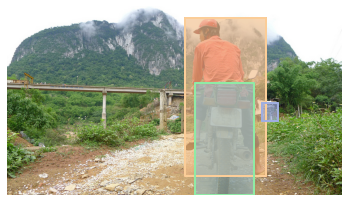

In [59]:
plt.imshow(img); plt.axis('off')
coco.showAnns(anns, draw_bbox=True)
# We can see that one of the objects gets lost, when we haven't predicted anything